In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from clean_and_preprocess import getPreprocessedData
from convert_data_to_process_predictions import convertDataToProcessPredictions
data = pd.read_csv("bank-additional-full.csv", ";")
plt.style.use("dark_background")

<AxesSubplot:>

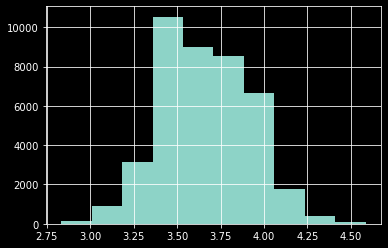

In [2]:
np.log(data["age"]).hist()

<AxesSubplot:>

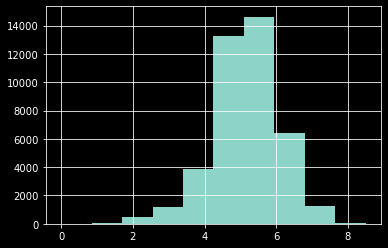

In [3]:
data["duration"].apply(lambda x: np.log(x) if x > 0 else 0).hist()

<AxesSubplot:>

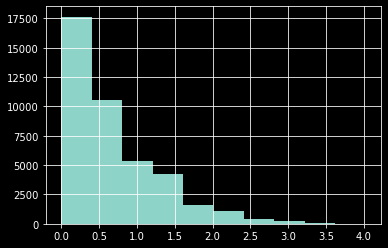

In [4]:
data["campaign"].apply(lambda x: np.log(x) if x > 0 else 0).hist()

<AxesSubplot:>

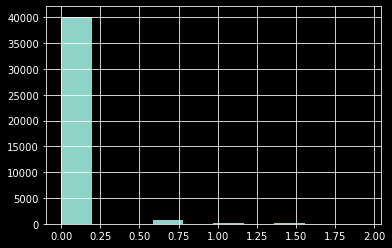

In [5]:
data["previous"].apply(lambda x: np.log(x) if x > 0 else 0).hist()

### age i duration zbliżyły się do rozkładu normalnego 

In [6]:
X_train = convertDataToProcessPredictions(data)
# Zamiana ['yes', 'no'] -> [1, 0], bo inaczej XGBoost się wywali
y_train = data.y.apply(lambda x: 1 if x == 'yes' else 0)

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### Patrzymy za pomocą Cross validation dokładność  wybranych algorytmów

In [8]:
%%time
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train,y_train,cv=10)
print(cv)
print(cv.mean())

[0.88055353 0.87205632 0.62102452 0.864773   0.802622   0.4044671
 0.36246662 0.35105608 0.65954347 0.5675085 ]
0.6386071146386738
Wall time: 663 ms


In [9]:
%%time
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train,y_train,cv=10)
print(cv)
print(cv.mean())

[0.88905074 0.88977907 0.8798252  0.88540908 0.89293518 0.88929352
 0.90434571 0.57052683 0.90140845 0.36255464]
0.8065128420269211
Wall time: 7.32 s


In [10]:
%%time
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train,y_train,cv=10)
print(cv)
print(cv.mean())

[0.88977907 0.86647244 0.72250546 0.85554746 0.84000971 0.8208303
 0.40349599 0.31561059 0.60611948 0.20325401]
0.6523624514076782
Wall time: 2.4 s


In [11]:
%%time
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=10)
print(cv)
print(cv.mean())

[0.88783685 0.8820102  0.83515416 0.86404467 0.86307356 0.84195193
 0.86283078 0.64554504 0.85721224 0.39800874]
0.7937668176980106
Wall time: 1min 7s


In [12]:
%%time
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.8873513  0.70308327 0.83697499 0.31054996 0.61879325]
0.6713505545813907
Wall time: 13min 4s


In [13]:
%%time
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.84826414 0.69919883 0.79776645 0.22872405 0.18829671]
0.5524500369206116
Wall time: 10.9 s


#### XGBoost zwraca niepokojące niskie wartośći dla dwóch ostatnich podziałów.

### Logistic regression i KNN mają najwyższą dokładność, więc w ich stronę byśmy się kierowali przewidując "y" dla nowych danych


### Sprawdźmy jeszcze LR na różnych parametrach i wybierzmy najlepszy.

In [14]:
from sklearn.model_selection import GridSearchCV 
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}
clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train, y_train)
print(best_clf_lr)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.5s


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [2000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             verbose=True)


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   51.2s finished


In [15]:
print('Best Score: ' + str(best_clf_lr.best_score_))
print('Best Parameters: ' + str(best_clf_lr.best_params_))
best_params = best_clf_lr.best_params_

Best Score: 0.888219930186105
Best Parameters: {'C': 0.0001, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}


#### Pobawimy się jeszcze w train_test_split z najlepszymi parametrami i zobaczymy z ciekawości jak zadziała

In [16]:
len(data.index)

41188

In [17]:
best_params

{'C': 0.0001, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}

In [18]:
from sklearn.model_selection import train_test_split
new_X_train, new_X_test,new_y_train, new_y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [19]:
from sklearn.metrics import accuracy_score
C, max_iter, penalty, solver = best_params
new_lr = LogisticRegression(
    penalty = best_params["penalty"], 
    C = best_params["C"], 
    max_iter = best_params["max_iter"], 
    solver = best_params["solver"]
)
new_lr_model = new_lr.fit(new_X_train, new_y_train)
new_predictions = new_lr_model.predict(new_X_test)

accuracy = accuracy_score(new_y_test, new_predictions)
print(accuracy)

0.8887054481887928
